In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve

In [3]:
df_train = pd.read_csv('./data/df_train.csv')
df_test = pd.read_csv('./data/df_test.csv')

In [4]:
df_train.columns

Index(['title', 'month', 'type_movie', 'type_tv', 'runtime', 'season_count',
       'episode_count', 'language', 'production_company_is_missing',
       'director_is_missing',
       ...
       'country_PL', 'country_RU', 'country_SE', 'country_TH', 'country_TR',
       'country_TW', 'country_US', 'country_US, GB', 'country_others',
       'success_label'],
      dtype='object', length=201)

In [5]:
print(df_train.shape)
print(df_test.shape)

(63278, 201)
(1477, 200)


In [ ]:
# 1. X, y 준비 (title, language 제거한 상태)
X = df_train.drop(columns=['success_label', 'title', 'language'])
y = df_train['success_label']
X_test = df_test.copy()

# 2. 컬럼명 특수문자 처리
def clean_column_names(df):
    df.columns = df.columns.str.replace(r'[,\s/\\]', '_', regex=True)
    return df

X = clean_column_names(X)
X_test = clean_column_names(X_test)

# 3. train/valid split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.25, random_state=26, stratify=y
)

In [ ]:
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method="hist",
    #use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)
y_valid_pred = xgb_model.predict(X_valid)
y_valid_prob_xgb = xgb_model.predict_proba(X_valid)[:, 1]

In [ ]:
# 정확도
acc = accuracy_score(y_valid, y_valid_pred)
print(f"Validation Accuracy: {acc:.4f}")

# F1-score (binary 기준)
f1 = f1_score(y_valid, y_valid_pred)
print(f"Validation F1-score: {f1:.4f}")

# ROC-AUC (확률 기반 평가)
roc_auc = roc_auc_score(y_valid, y_valid_prob_xgb)
print(f"Validation ROC-AUC: {roc_auc:.4f}")

# 좀 더 자세한 리포트
print(classification_report(y_valid, y_valid_pred))


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import lightgbm as lgb
import xgboost as xgb

# 1. 데이터 준비
X = df_train.drop(columns=['success_label', 'title', 'language'])
y = df_train['success_label']
X_test = df_test.copy()

# 2. 특수문자 컬럼명 처리
def clean_column_names(df):
    df.columns = df.columns.str.replace(r'[,\s/\\]', '_', regex=True)
    return df

X = clean_column_names(X)
X_test = clean_column_names(X_test)

# 3. train/validation 분할
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.25, random_state=26, stratify=y
)

# 4. LightGBM 모델
model_lgb = lgb.LGBMClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model_lgb.fit(X_train, y_train)
proba_lgb = model_lgb.predict_proba(X_valid)[:, 1]

# 5. XGBoost 모델
model_xgb = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
model_xgb.fit(X_train, y_train)
proba_xgb = model_xgb.predict_proba(X_valid)[:, 1]

# 6. Soft Voting 앙상블
ensemble_proba = (proba_lgb + proba_xgb) / 2

# 7. Threshold 설정
threshold = 0.21
ensemble_preds = (ensemble_proba >= threshold).astype(int)

# 8. 평가
print("== LightGBM + XGBoost Soft Voting Ensemble ==")
print(classification_report(y_valid, ensemble_preds, digits=4))
print("Accuracy:", accuracy_score(y_valid, ensemble_preds))
print("Precision:", precision_score(y_valid, ensemble_preds))
print("Recall:", recall_score(y_valid, ensemble_preds))
print("F1 Score:", f1_score(y_valid, ensemble_preds))
print("ROC-AUC:", roc_auc_score(y_valid, ensemble_proba))


[LightGBM] [Info] Number of positive: 9802, number of negative: 37656
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26697
[LightGBM] [Info] Number of data points in the train set: 47458, number of used features: 197
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.206541 -> initscore=-1.345906
[LightGBM] [Info] Start training from score -1.345906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:32:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


== LightGBM + XGBoost Soft Voting Ensemble ==
              precision    recall  f1-score   support

           0     0.9289    0.7718    0.8431     12553
           1     0.4685    0.7729    0.5834      3267

    accuracy                         0.7721     15820
   macro avg     0.6987    0.7724    0.7133     15820
weighted avg     0.8338    0.7721    0.7895     15820

Accuracy: 0.7720606826801517
Precision: 0.468547040267211
Recall: 0.7728803183348638
F1 Score: 0.5834103512014788
ROC-AUC: 0.8501499525086789


In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score

best_result = None
print("Thresh | Precision | Recall | F1")
for thresh in np.arange(0.05, 0.91, 0.01):
    preds = (ensemble_proba >= thresh).astype(int)
    precision = precision_score(y_valid, preds)
    recall = recall_score(y_valid, preds)
    f1 = f1_score(y_valid, preds)
    
    print(f"{thresh:.2f}     | {precision:.4f}   | {recall:.4f} | {f1:.4f}")
    
    if precision >= 0.55:
        best_result = (thresh, precision, recall, f1)
        break  # 가장 낮은 threshold 중 처음으로 조건 만족하는 지점 찾기

if best_result:
    t, p, r, f = best_result
    print("\n🎯 Best threshold satisfying Precision ≥ 0.55:")
    print(f"Threshold: {t:.2f} | Precision: {p:.4f} | Recall: {r:.4f} | F1: {f:.4f}")
else:
    print("\n⚠️ No threshold found where precision ≥ 0.55.")


Thresh | Precision | Recall | F1
0.05     | 0.2585   | 0.9731 | 0.4085
0.06     | 0.2748   | 0.9617 | 0.4274
0.07     | 0.2899   | 0.9519 | 0.4444
0.08     | 0.3046   | 0.9434 | 0.4605
0.09     | 0.3172   | 0.9299 | 0.4731
0.10     | 0.3294   | 0.9216 | 0.4853
0.11     | 0.3399   | 0.9094 | 0.4949
0.12     | 0.3529   | 0.8993 | 0.5069
0.13     | 0.3658   | 0.8886 | 0.5182
0.14     | 0.3777   | 0.8766 | 0.5280
0.15     | 0.3899   | 0.8644 | 0.5374
0.16     | 0.4052   | 0.8522 | 0.5493
0.17     | 0.4182   | 0.8378 | 0.5579
0.18     | 0.4305   | 0.8191 | 0.5644
0.19     | 0.4447   | 0.8041 | 0.5727
0.20     | 0.4570   | 0.7882 | 0.5785
0.21     | 0.4685   | 0.7729 | 0.5834
0.22     | 0.4808   | 0.7533 | 0.5869
0.23     | 0.4950   | 0.7407 | 0.5934
0.24     | 0.5074   | 0.7242 | 0.5967
0.25     | 0.5185   | 0.7092 | 0.5990
0.26     | 0.5293   | 0.6918 | 0.5997
0.27     | 0.5391   | 0.6758 | 0.5998
0.28     | 0.5473   | 0.6627 | 0.5995
0.29     | 0.5574   | 0.6498 | 0.6001

🎯 Best threshold

In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.arange(0.1, 0.9, 0.01)

best_result = {'threshold': None, 'precision': 0, 'recall': 0, 'f1': 0}

print("Thresh\tPrec\tRec\tF1")
for t in thresholds:
    preds = (ensemble_proba >= t).astype(int)
    prec = precision_score(y_valid, preds)
    rec = recall_score(y_valid, preds)
    f1 = f1_score(y_valid, preds)
    print(f"{t:.2f}\t{prec:.3f}\t{rec:.3f}\t{f1:.3f}")
    
    if prec >= 0.55 and f1 > best_result['f1']:
        best_result = {'threshold': t, 'precision': prec, 'recall': rec, 'f1': f1}

print("\n📌 Best Threshold with Precision ≥ 0.55:")
print(best_result)


Thresh	Prec	Rec	F1
0.10	0.329	0.922	0.485
0.11	0.340	0.909	0.495
0.12	0.353	0.899	0.507
0.13	0.366	0.889	0.518
0.14	0.378	0.877	0.528
0.15	0.390	0.864	0.537
0.16	0.405	0.852	0.549
0.17	0.418	0.838	0.558
0.18	0.431	0.819	0.564
0.19	0.445	0.804	0.573
0.20	0.457	0.788	0.579
0.21	0.469	0.773	0.583
0.22	0.481	0.753	0.587
0.23	0.495	0.741	0.593
0.24	0.507	0.724	0.597
0.25	0.518	0.709	0.599
0.26	0.529	0.692	0.600
0.27	0.539	0.676	0.600
0.28	0.547	0.663	0.599
0.29	0.557	0.650	0.600
0.30	0.564	0.630	0.595
0.31	0.574	0.615	0.594
0.32	0.586	0.600	0.593
0.33	0.594	0.588	0.591
0.34	0.602	0.574	0.588
0.35	0.611	0.563	0.586
0.36	0.617	0.552	0.583
0.37	0.626	0.542	0.581
0.38	0.632	0.526	0.574
0.39	0.642	0.516	0.572
0.40	0.652	0.508	0.571
0.41	0.660	0.499	0.568
0.42	0.666	0.489	0.564
0.43	0.672	0.479	0.559
0.44	0.679	0.469	0.555
0.45	0.688	0.459	0.551
0.46	0.693	0.448	0.544
0.47	0.698	0.436	0.537
0.48	0.704	0.424	0.529
0.49	0.717	0.415	0.525
0.50	0.720	0.402	0.516
0.51	0.728	0.391	0.509
0.52	0.737	0.38

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report
)
import lightgbm as lgb
import xgboost as xgb

# 1. X, y 준비
X = df_train.drop(columns=['success_label', 'title', 'language'])
y = df_train['success_label']
X_test = df_test.copy()

# 2. 컬럼명 특수문자 처리
def clean_column_names(df):
    df.columns = df.columns.str.replace(r'[,\s/\\]', '_', regex=True)
    return df

X = clean_column_names(X)
X_test = clean_column_names(X_test)

# 3. train/valid split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.25, random_state=26, stratify=y
)

# 4. LightGBM 모델 학습
lgb_model = lgb.LGBMClassifier(
    n_estimators=100, max_depth=6, learning_rate=0.1,
    subsample=0.8, colsample_bytree=0.8, random_state=42
)
lgb_model.fit(X_train, y_train)
y_valid_proba_lgb = lgb_model.predict_proba(X_valid)[:, 1]

# 5. XGBoost 모델 학습
xgb_model = xgb.XGBClassifier(
    n_estimators=100, max_depth=6, learning_rate=0.1,
    subsample=0.8, colsample_bytree=0.8, use_label_encoder=False,
    eval_metric='logloss', random_state=42
)
xgb_model.fit(X_train, y_train)
y_valid_proba_xgb = xgb_model.predict_proba(X_valid)[:, 1]

# 6. Soft voting 앙상블
ensemble_proba = (y_valid_proba_lgb + y_valid_proba_xgb) / 2

# 7. Threshold 최적화 (Precision ≥ 0.55)
best_threshold = None
for t in np.arange(0.05, 0.91, 0.01):
    preds = (ensemble_proba >= t).astype(int)
    precision = precision_score(y_valid, preds)
    if precision >= 0.55:
        best_threshold = t
        break

if best_threshold is None:
    best_threshold = 0.5  # fallback

print(f"\n🎯 선택된 Threshold: {best_threshold:.2f}")

# 8. 최종 성능 평가
final_preds = (ensemble_proba >= best_threshold).astype(int)

print("\n== 최종 Validation 성능 (Ensemble) ==")
print(classification_report(y_valid, final_preds))
print("Accuracy:", accuracy_score(y_valid, final_preds))
print("Precision:", precision_score(y_valid, final_preds))
print("Recall:", recall_score(y_valid, final_preds))
print("F1 Score:", f1_score(y_valid, final_preds))
print("ROC-AUC:", roc_auc_score(y_valid, ensemble_proba))

[LightGBM] [Info] Number of positive: 9802, number of negative: 37656
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26697
[LightGBM] [Info] Number of data points in the train set: 47458, number of used features: 197
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.206541 -> initscore=-1.345906
[LightGBM] [Info] Start training from score -1.345906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:38:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🎯 선택된 Threshold: 0.29

== 최종 Validation 성능 (Ensemble) ==
              precision    recall  f1-score   support

           0       0.90      0.86      0.88     12553
           1       0.55      0.64      0.60      3267

    accuracy                           0.82     15820
   macro avg       0.73      0.75      0.74     15820
weighted avg       0.83      0.82      0.82     15820

Accuracy: 0.8193426042983565
Precision: 0.5537733368393374
Recall: 0.6446280991735537
F1 Score: 0.5957567185289958
ROC-AUC: 0.84941354625168


In [12]:
# 9. X_test에 적용 (비수치형 컬럼 제거 및 정렬 맞춤)
X_test_model = X_test.drop(columns=['title', 'language'], errors='ignore')  # 문자열 컬럼 제거
X_test_model = clean_column_names(X_test_model)  # 컬럼명 정리

# 학습 때 쓰인 컬럼 순서대로 맞추기 (필요하면)
X_test_model = X_test_model[X.columns]

y_test_proba_lgb = lgb_model.predict_proba(X_test_model)[:, 1]
y_test_proba_xgb = xgb_model.predict_proba(X_test_model)[:, 1]
ensemble_test_proba = (y_test_proba_lgb + y_test_proba_xgb) / 2
test_preds = (ensemble_test_proba >= best_threshold).astype(int)

# 결과 저장
df_test['success_prob'] = ensemble_test_proba
df_test['success_pred'] = test_preds

# 상위 성공 확률 영화 보기
top_movies = df_test.sort_values(by='success_prob', ascending=False).head(10)
print("\n🎬 성공 확률 높은 상위 10개 영화:")
print(top_movies[['success_prob', 'success_pred']])


🎬 성공 확률 높은 상위 10개 영화:
     success_prob  success_pred
12       0.951382             1
16       0.949046             1
13       0.938175             1
158      0.920028             1
168      0.918170             1
471      0.918025             1
84       0.917302             1
88       0.916607             1
379      0.913797             1
101      0.909909             1


In [13]:
df_test.head()

,title,month,type_movie,type_tv,runtime,season_count,episode_count,language,production_company_is_missing,director_is_missing,...,country_RU,country_SE,country_TH,country_TR,country_TW,country_US,"country_US, GB",country_others,success_prob,success_pred
0,STRAW,6,1,0,105.0,1.0,1.0,en,0,0,...,0,0,0,0,0,1,0,0,0.873859,1
1,Predator: Killer of Killers,6,1,0,85.0,1.0,1.0,en,0,0,...,0,0,0,0,0,1,0,0,0.879264,1
2,How to Train Your Dragon,6,1,0,125.0,1.0,1.0,en,0,0,...,0,0,0,0,0,1,0,0,0.824530,1
3,Deep Cover,6,1,0,99.0,1.0,1.0,en,0,0,...,0,0,0,0,0,1,0,0,0.861639,1
4,K.O.,6,1,0,84.0,1.0,1.0,fr,0,0,...,0,0,0,0,0,0,0,0,0.557606,1


In [15]:
df_test.sort_values(by='success_prob', ascending=True)

,title,month,type_movie,type_tv,runtime,season_count,episode_count,language,production_company_is_missing,director_is_missing,...,country_RU,country_SE,country_TH,country_TR,country_TW,country_US,"country_US, GB",country_others,success_prob,success_pred
486,Memory Lane,6,1,0,5.0,1.0,1.0,id,1,0,...,0,0,0,0,0,0,0,0,0.008773,0
1024,Downstream,6,1,0,3.0,1.0,1.0,en,1,0,...,0,0,0,0,0,0,0,0,0.008907,0
1371,旅行最紧要近,6,0,1,23.0,1.0,0.0,zh,1,1,...,0,0,0,0,0,0,0,0,0.009342,0
1242,"Kita Yakin, Mereka Yakin",6,1,0,12.0,1.0,1.0,id,0,0,...,0,0,0,0,0,0,0,0,0.011504,0
937,The Man in the Rectangle,6,1,0,25.0,1.0,1.0,en,1,0,...,0,0,0,0,0,0,0,0,0.011580,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,Eye for an Eye,6,1,0,97.0,1.0,1.0,en,0,0,...,0,0,0,0,0,1,0,0,0.918170,1
158,Deliver Me from Nowhere,10,1,0,151.0,1.0,1.0,en,0,0,...,0,0,0,0,0,1,0,0,0.920028,1
13,Jurassic World Rebirth,7,1,0,134.0,1.0,1.0,en,0,0,...,0,0,0,0,0,1,0,0,0.938175,1
16,Superman,7,1,0,129.0,1.0,1.0,en,0,0,...,0,0,0,0,0,1,0,0,0.949046,1


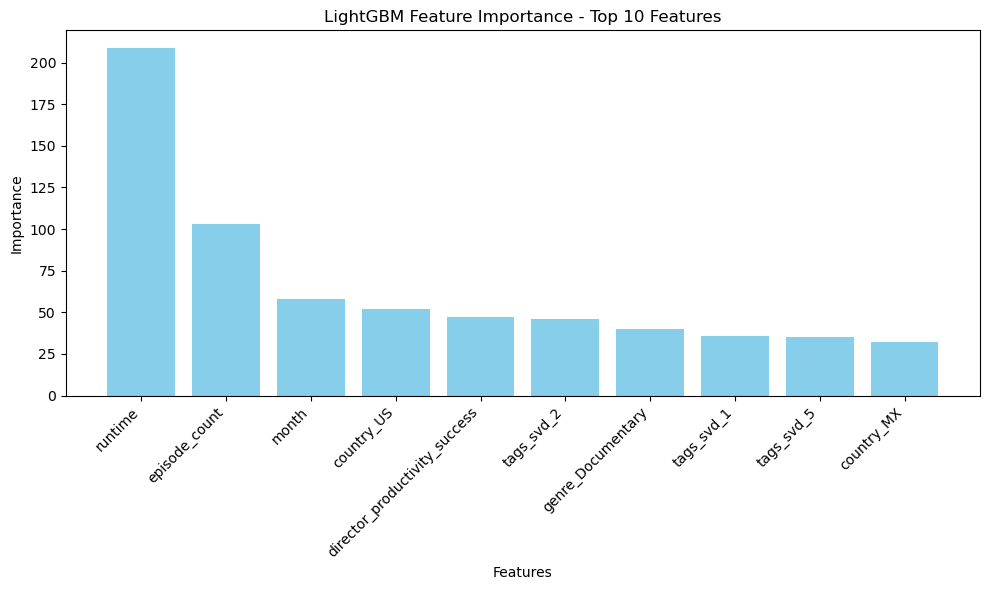

In [17]:
import matplotlib.pyplot as plt
import numpy as np

importances = lgb_model.feature_importances_
indices = np.argsort(importances)[::-1]

top_n = 10
features_sorted = [X.columns[i] for i in indices[:top_n]]

plt.figure(figsize=(10, 6))
plt.title("LightGBM Feature Importance - Top 10 Features")
plt.bar(range(top_n), importances[indices][:top_n], color='skyblue')
plt.xticks(range(top_n), features_sorted, rotation=45, ha='right')
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


In [18]:
print(y.value_counts())
print(y.value_counts(normalize=True))


success_label
0    50209
1    13069
Name: count, dtype: int64
success_label
0    0.793467
1    0.206533
Name: proportion, dtype: float64
